# <center>Лекція 8. Online Learning with Gigabytes of Data (Навчання з гігабайтами даних)</center>

# Outline
1. Stochastic gradient descent and online learning
    - 1.1. SGD
    - 1.2. Online approach to learning
2. Categorical data processing: Label Encoding, One-Hot Encoding, Hashing trick
    - 2.1. Label Encoding
    - 2.2. One-Hot Encoding
    - 2.3. Hashing trick
3. Vowpal Wabbit
    - 3.1. News. Binary classification
    - 3.2. News. Multiclass classification
    - 3.3. IMDB reviews
    - 3.4. Classifying gigabytes of StackOverflow questions
4. VW and Spooky Author Identification

This week, we’ll cover two reasons for Vowpal Wabbit’s exceptional training speed, namely, online learning and hashing trick, in both theory and practice. We will try it out with news, movie reviews, and StackOverflow questions.

In [5]:
import warnings
warnings.filterwarnings('ignore')
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1. Stochastic gradient descent and online learning
##  1.1. Stochastic gradient descent

Despite the fact that gradient descent is one of the first things learned in machine learning and optimization courses, it is hard to overrate one of it's modifications, namely, Stochastic Gradient Descent (SGD).

Lets recap that the very idea of gradient descent is to minimize some function by making small steps in the direction of fastest function decreasing. The method was named due to the following fact from calculus: vector $\nabla f = (\frac{\partial f}{\partial x_1}, \ldots \frac{\partial f}{\partial x_n})^T$ of partial derivatives of the function $f(x) = f(x_1, \ldots x_n)$ points to the direction of the fastest function growth. It means that by moving in the opposite direction (antigradient) it is possible to decrease the function value with the fastest rate.

<img src='https://habrastorage.org/files/4f2/75d/a46/4f275da467a44fc4a8d1a11007776ed2.jpg' width=40%>

Here is a snowboarder (me) in Sheregesh, Russian most popular winter resort. I highly recommended it if you like skiing or snowboarding. We place this picture not only for a good view but also for picturing the idea of gradient descent. If you have an aim to ride as fast as possible, you need to choose the way with steepest descent (as long as you stay alive). Calculating antigradient can be seen as evaluating the slope in each particular point.

**Example**

The paired regression problem can be solved with gradient descent. Let us predict one variable with another, say, height with weight and assume that these variables are lineary dependent. Here we are using the SOCR dataset. 

In [6]:
# Change the code below to your actual path 
PATH_TO_ALL_DATA = r'D:/GitHub/Intelligent-data-analysis-temp/01_lecture-notes/ida_lecture-08_online-learning/input/spooky-vw-tutorial/'

data_demo = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, 'weights_heights.csv'))

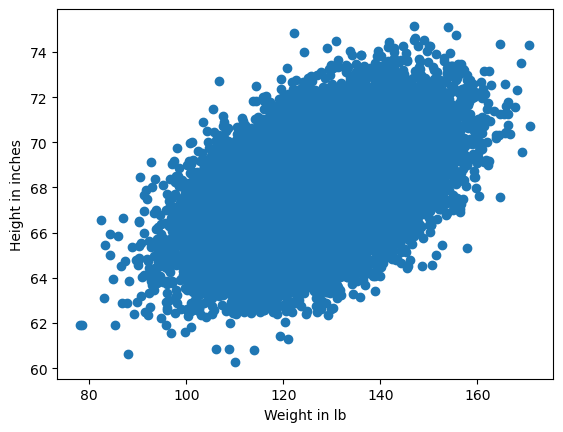

In [7]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Weight in lb')
plt.ylabel('Height in inches');

Here we have a vector $x$ of dimension $\ell$ (weight of every person, i.e. training sample) and $y$, a vector which stores heights of every person in the dataset. 

The task is the following: find weights $w_0$ and $w_1$ such that predicting height with weight as $y_i = w_0 + w_1 x_i$ (where $y_i$ is $i$-th height value, $x_i$ is $i$-th weight value) minimizes the squared error (as well as mean squared error as $\frac{1}{\ell}$ doesn't make any difference ):
$$SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow min_{w_0,w_1}$$

We will use gradient descent, utilizing partial derivatives of $SE(w_0, w_1)$ over weights $w_0$ and $w_1$.
An iterative training procedure is then defined by simple weight update formulas (we change model weights in small steps, proportionally to a small constant $\eta$, towards antigradient of the function $SE(w_0, w_1)$):

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} -\eta \frac{\partial SE}{\partial w_0} |_{t} \\  w_1^{(t+1)} = w_1^{(t)} -\eta \frac{\partial SE}{\partial w_1} |_{t} \end{array}$$

Diving in into analytical computing of partial derivatives, we get the following: 

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta \sum_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

This math works quite well until the amount of data isn't very huge (we will not discuss issues with local minima, saddle points, choosing the value of learning rate (gradient descent step), moments and other stuff – lots these topics are well presented in [chapter](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" in "Deep Learning" book). 
There is an issue with this approach (batch gradient descent) - gradient evaluation requires the summation of some values for every object from training set. In other words, the algorithm requires a lot of iterations, at every iteration we have to recompute weights with formula which have a sum $\sum_{i=1}^\ell$ over the whole training set. What if we have billions of training samples?

<img src="https://habrastorage.org/webt/ow/ng/cs/owngcs-lzoguklv1pn9vz_r4ssm.jpeg" />

Here goes stochastic gradient descent! Simply, we throw away the summation sign and update the weights only over single training samples (or some dozen of them). Considering our case:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

With this approach there is no guarantee that we will move in best possible direction at every iteration and we might need many more iterations, but we get virtually instant weight updates.

Andrew Ng has a good illustration in his machine learning [course](https://www.coursera.org/learn/machine-learning), lets take a look at it.

<img align="center" src="https://habrastorage.org/files/f8d/90c/f83/f8d90cf83b044255bb07df3373f25fc7.png" width="500">

Here are contour plots of some function and we are looking for the global minimum of this function. The red curve shows weight changes (in this picture $\theta_0$ and $\theta_1$ correspond  to $w_0$ and $w_1$ in our example). According to the properties of a gradient, the direction of change in every point is orthogonal to contour plots. With stochastic gradient descent weights are changing in a less predictible manner and it even may seem that some steps are wrong – leading away from minima, but both procedures converge to the same solution.

## 1.2. Online approach to learning
Stochastic gradient descent, being one of optimization methods, gives us practical guidance for training both classifiers and regressors with huge amounts of data, up to hundreds of GiBs (depending on the computational resources on one's disposal).

Considering the case of paired regression, we can store the training data set $(X,y)$ in HDD without loading it into RAM (it simply won't fit), read objects one by one and update the weights of our model:

$$\begin{array}{rcl} w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\  w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i \end{array}$$

After working out the whole training dataset, the loss function we are trying to minimize (quadratic squared root error in case of regression or, for example, logistic loss for classification task), will decrease, but usually it takes dozens of passes over the training set to make the loss small enough. 

This approach to learning is usually called **online learning**, and this name emerged even before machine learning MOOC-s turned mainstream.

We do not discuss many  specific things about SGD and if you want do dive into theory, a good choice is ["Convex Optimization" book by  Boyd](https://www.amazon.com/Convex-Optimization-Stephen-Boyd/dp/0521833787)). Instead, we will introduce the Vowpal Wabbit library, which is good for training simple models with huge data sets thanks to stochastic optimization and another trick – feature hashing, which we are introducing in the next part of the tutorial.

In Scikit-learn classifiers and regressors, trained with SGD, are named  `SGDClassifier` and `SGDRegressor` from `sklearn.linear_model`. These are nice implementations of SGD but we'll focus on VW as being superior to sklearn's SGD models in many aspects including computational performance.

# 2. Categorial features processing: Label Encoding, One-Hot Encoding and Hashing trick

## 2.1. Label Encoding
Many classification and regression algorithms operate in euclidean or metric spaces, implying that data is represented with vectors of real numbers. However, in real data we often meet categorial features with discrete values range, like yes/no or  January/February/.../December. We will see how to process this kind of data, particularly with linear models and how to deal with lots of categorial features even when these features have lots of unique values.

Here we explore the UCI bank marketing [dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing), where most of  features are categorial.

In [8]:
df = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, 'bank_train.csv'))
labels = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                  'bank_train_target.csv'), header=None)

print(df.head())

   age          job  marital          education  default housing loan  \
0   26      student   single        high.school       no      no   no   
1   46       admin.  married  university.degree       no     yes   no   
2   49  blue-collar  married           basic.4y  unknown     yes  yes   
3   31   technician  married  university.degree       no      no   no   
4   42    housemaid  married  university.degree       no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0  telephone   jun         mon       901         1    999         0   
1   cellular   aug         tue       208         2    999         0   
2  telephone   jun         tue       131         5    999         0   
3   cellular   jul         tue       404         1    999         0   
4  telephone   nov         mon        85         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent           1.4          94.465          -41.8 

We see, most of features are not represented by numbers. It poses a problem: we cannot use most of machine learning methods (at least those imlemented in Scikit-learn) out-of-the-box.

Let's explore the feature "education".

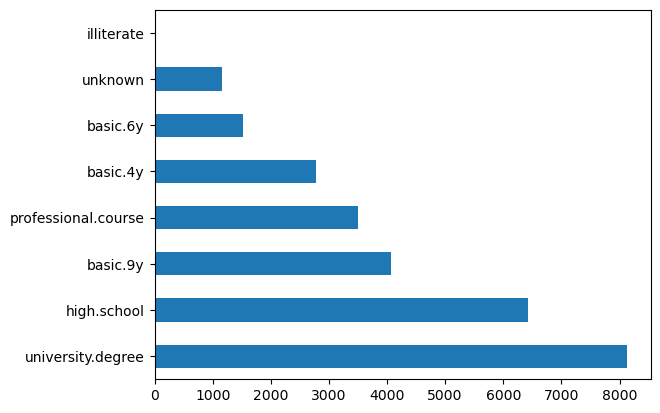

In [9]:
df['education'].value_counts().plot.barh();

The most straightforward solution would be to map each value of this feature into a unique number. For example we can map  `university.degree` to 0, `basic.9y` to 1 and so on. One can use `sklearn.preprocessing.LabelEncoder` to perform this mapping.

In [10]:
label_encoder = LabelEncoder()

The `fit` method of this class finds all unique values and builds the actual mapping between categories and numbers, and the `transform` method  converts categories into numbers. After `fit` is executed, `label_encoder` will have the `classes_` attribute, with all unique values of the feature. Let us count them to make sure the transformation was correct.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


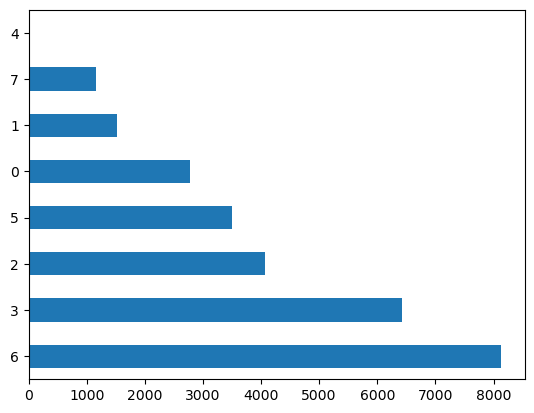

In [11]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

In [12]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Let's apply such transformation to all columns with type `object`.

In [13]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


The main issue with this approach is that we've introduced some order while there might haven't been such.  

For example, we implicitly introduced algebra over the values of the job feature, now we can substract the job of client #2 from the job of client #1 :

In [14]:
df.loc[1].job - df.loc[2].job

-1.0

Does this operation make sense? Maybe not. Let's try to train logisitic regression with this feature transformation.

In [15]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.to_numpy()  # or you can use dataframe.values
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
    
    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      6081
           1       0.67      0.00      0.00       818

    accuracy                           0.88      6899
   macro avg       0.77      0.50      0.47      6899
weighted avg       0.86      0.88      0.83      6899



We can see that logistic regression hasn't ever predicted class 1. In order to use linear models with categorial features we will take a different approach - One-Hot Encoding.

## 2.2. One-Hot Encoding

Suppose that some feature can have one of 10 unique values. In this case one-hot encoding creates 10 new features corresponding to these unique values, all of them *except one* are zeros.

In [16]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


This idea is implemented in the `OneHotEncoder` class from `sklearn.preprocessing`. By default `OneHotEncoder` transforms data into a sparse matrix for the sake of saving memory space - most of the values are zeroes and we don't want to spare extra RAM. However, in this particular example we don't run into such problems, so we are going to use "dense" matrix representation.

In [17]:
onehot_encoder = OneHotEncoder(sparse=False)

In [18]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We've got 53 columns that correspond to the number of unique values of categorical features in our data set. When transformed with One-Hot Encoding, this data can be used with linear models:

In [19]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      6110
           1       0.57      0.16      0.26       789

    accuracy                           0.89      6899
   macro avg       0.74      0.57      0.60      6899
weighted avg       0.86      0.89      0.86      6899



## 2.3. Hashing trick
Real data can be even more volatile, we cannot guarantee that new values  of categorial features will not occur. This issue hampers the using ot the trained model with some new data. Besides that, `LabelEncoder` assumes preliminary analysis of the whole dataset and storage of constructed mappings in memory, which makes it difficult to work with big amounts of data.

There is a simple approach to vectorization of categorial data, it is based on hashing, and is known as, surprisingly, the hashing trick. 

Hash functions can help us in finding unique codes for different feature values, for example:

In [20]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> 5221011964671493708
high.school -> -2450853399563062259
illiterate -> -440573875518933021


We don't use negative values or values of such high magnitude. We restrict the range of values for the hash function:

In [21]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 8
high.school -> 16
illiterate -> 4


Imagine that our data set contains a single (not married yet) student, who received a call on Monday. His feature vectors  will be created similarly to the case of One-Hot Encoding, but in the united space with fixed range for all features:

In [22]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 10
marital=single -> 17
day_of_week=mon -> 18


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


We want to point out: we hash not only feature values, but pairs of **feature name + feature value**. It's important to distinguish the same values of different features.

In [23]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Is it possible that we have a collision (when hash codes, computed for two different combinations of feature names and values, coincide)? Sure, it is. But it can be seen that it is a rare case, with big enough  hashing spaces. And  even if the collision occurs, regression or classification metrics will not suffer much. Surprisingly, hash collisions in this case work as a sort of regularization.

<img align="center" src="https://habrastorage.org/webt/4o/wx/59/4owx59vdvwc9mzrf81t2fa2rqrc.jpeg" width="300">

Perhaps, you ask "WTF?", hashing seems counterintuitive. Maybe, but sometimes this heuristics is in fact the only plausible approach to work with categorial data. Moreover, this technique has proved to just work. 

# 3. Vowpal Wabbit

[Vowpal Wabbit](https://github.com/JohnLangford/vowpal_wabbit) (VW) is one of the most wide-spread machine learning libraries in industry. It is prominent for high training speed and support of many training modes. Especially, we are interested in online learning with big and high-dimentional data. This is one of major merits of the library. Also, with hashing trick implemented, Vowpal Wabbit is a perfect choice for working with text data.

Shell is the main interface for VW. Well... I haven't found the way of installing VW in a Kaggle Kernel (hmm.. Kaggle, what about Docker?) so I've commented out the code in some cells in order not to spoil the output. 

In [24]:
# !vw --help

Vowpal Wabbit reads data from files or from standard input stream (stdin) assuming the following format:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]` `Features=(String[:Value] )*`

here [] denotes non-mandatory elements, and (...)\* means some repeats. 

- **Label** is a number. In case of classification it is usually 1 and -1, in case of regression it is some real float value
- **Importance** is a number, it denotes sample weight during training. Setting this helps when working with imbalanced data.
- **Tag** is some string without spaces - it is a "name" of sample, VW saves it upon prediction. In order to separate Tag and Importance it is better to start Tag with the ' character.
- **Namespace** is for creation of separate feature spaces. 
- **Features** are object features inside **Namespace**. Features have weight 1.0 by default, but it can be changed, for example - feature:0.1.

The following string matches the VW format:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```

Let's check it and run VW with this training sample:

In [25]:
#! echo '1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park' | vw

VW is a wonderful tool for working with text data. We'll illustrate it with the [20newsgroups dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html), containing letters from 20 different news letters.

## 3.1. News. Binary classification.

In [27]:
# load data with sklearn's function 
newsgroups = fetch_20newsgroups(data_home=PATH_TO_ALL_DATA, subset='train')

In [28]:
newsgroups['target_names']

Lets look at the first document from this collection:

In [29]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Now we convert the data into something Vowpal Wabbit can understand, and we throw away words shorter than of 3 symbols. Here we skip many important NLP stages (stemming and lemmatization, for example), however, we will later see that VW solves the problem even without these steps.

In [30]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

We split the dataset into train and test and write these to files. We will consider document as positive, if it corresponds to **rec.autos**. Thus, we construct the model which distinguishes letters about cars from others: 

In [ ]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [ ]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
# with open(os.path.join(PATH_TO_ALL_DATA, '20news_train.vw'), 'w') as vw_train_data:
#     for text, target in zip(train_documents, train_labels):
#         vw_train_data.write(to_vw_format(text, target))
# with open(os.path.join(PATH_TO_ALL_DATA, '20news_test.vw'), 'w') as vw_test_data:
#     for text in test_documents:
#         vw_test_data.write(to_vw_format(text))

And now we pass the created file to Vowpal Wabbit. We solve the classification problem with hinge loss function (linear SVM). The trained model will be saved in the `20news_model.vw` file:

In [ ]:
# !vw -d $PATH_TO_ALL_DATA/20news_train.vw \
#  --loss_function hinge -f $PATH_TO_ALL_DATA/20news_model.vw

Training is finished. VW prints a lot of interesting info while training (one can supress it with the `--quiet` parameter). More on this diagnostic output can be seen on [GitHub](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Note how average loss drops while training. For loss computation VW uses samples it has never seen before, so this measure is usually correct. Now we apply trained model to the test set, saving predictions into a file with the `-p` flag:  

In [ ]:
# !vw -i $PATH_TO_ALL_DATA/20news_model.vw -t -d $PATH_TO_ALL_DATA/20news_test.vw \
# -p $PATH_TO_ALL_DATA/20news_test_predictions.txt

Now we load predictions, compute AUC and plot the ROC curve:

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, '20news_test_predictions.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
roc_curve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(roc_curve[0], roc_curve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);

AUC value we get states that here we've achieved high classification quality.

# 3.2. News. Multiclass classification

We use same news dataset, but this time we solve multiclass classification problem. `Vowpal Wabbit` is a little picky – it loves labels starting from 1 till K, where K – is a number of classes in classification task (20 in our case). So we will use LabelEncoder and add 1 afterwards (`LabelEncoder` maps labels into range from 0 to K-1).

In [ ]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Data is the same, but we change labels, train_labels_mult and test_labels_mult – label vectors from 1 to 20.**

In [ ]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)
    
# with open(os.path.join(PATH_TO_ALL_DATA, '20news_train_mult.vw'), 'w') as vw_train_data:
#     for text, target in zip(train_documents, train_labels_mult):
#         vw_train_data.write(to_vw_format(text, target))
# with open(os.path.join(PATH_TO_ALL_DATA, '20news_test_mult.vw'), 'w') as vw_test_data:
#     for text in test_documents:
#         vw_test_data.write(to_vw_format(text))

We train Vowpal Wabbit in multiclass classification mode, passing `oaa` parameter("one against all"), with number of classes. Also, lets see parameters we can tune and model quality can be very depended on them (more info – in the official Vowpal Wabbit [tutorial](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial)):
 - learning rate (-l, 0.5 default) – rate of weight change on every step
 - learning rate decay (--power_t, 0.5 default) – it is proven by practice, that if learning rate drops along with further steps of stochastic gradient descent, we approach loss minimum better
 - loss function (--loss_function) – entire training algorithm depends on it. [Docs](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions) about loss functions
 - Regularization (-l1) – note, that VW  calculates regularization for every object, that why we usually set regularization values small, about $10^{-20}.$
 
 Additionally we can try automatic Vowpal Wabbit parameters tuning with [Hyperopt](https://github.com/hyperopt/hyperopt).

In [ ]:
# %%time
# !vw --oaa 20 $PATH_TO_ALL_DATA/20news_train_mult.vw -f $PATH_TO_ALL_DATA/20news_model_mult.vw \
# --loss_function=hinge

In [ ]:
# %%time
# !vw -i $PATH_TO_ALL_DATA/20news_model_mult.vw -t -d $PATH_TO_ALL_DATA/20news_test_mult.vw \
# -p $PATH_TO_ALL_DATA/20news_test_predictions_mult.txt

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, '20news_test_predictions_mult.txt')) as pred_file:
    test_prediction_mult = [float(label) for label in pred_file.readlines()]

In [ ]:
accuracy_score(test_labels_mult, test_prediction_mult)

Here is how often the model misclassifies atheism with other topics.

In [ ]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0,i])

# 3.3. IMDB movie reviews
In this part we will do binary classification of [IMDB](http://www.imdb.com) (International Movie DataBase) movie reviews. We will see how fast Vowpal Wabbit is.

Using the `load_files` function from `sklearn.datasets` we load movie reviews [from here](https://yadi.sk/d/Tg1Tflur333iLr). If you want to reproduce the results, please download the archive, unzip it and set the path to `imdb_reviews` (it will contain *train* and *test* subdirectories). Unpacking can take several minutes as there are 100k of files. Both train and test sets hold 12500 good and bad movie reviews. First we split texts and labels.

In [ ]:
import pickle

In [ ]:
# path_to_movies = os.path.expanduser('/Documnents/imdb_reviews')
# reviews_train = load_files(os.path.join(path_to_movies, 'train'))
with open(os.path.join(PATH_TO_ALL_DATA, 'reviews_train.pkl'), 'rb') as reviews_train_pkl:
    reviews_train = pickle.load(reviews_train_pkl)
text_train, y_train = reviews_train.data, reviews_train.target

In [ ]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

The same for the test set.

In [ ]:
# reviews_test = load_files(os.path.join(path_to_movies, 'test'))
with open(os.path.join(PATH_TO_ALL_DATA, 'reviews_test.pkl'), 'rb') as reviews_test_pkl:
    reviews_test = pickle.load(reviews_test_pkl)
text_test, y_test = reviews_test.data, reviews_train.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Examples of some reviews and corresponding labels.

In [ ]:
text_train[0]

In [ ]:
y_train[0] # good review

In [ ]:
text_train[1]

In [ ]:
y_train[1] # bad review

In [ ]:
to_vw_format(str(text_train[1]), 1 if y_train[0] == 1 else -1)

Now we prepare training (`movie_reviews_train.vw`), validation (`movie_reviews_valid.vw`) and test (`movie_reviews_test.vw`) sets for Vowpal Wabbit. 70% of training set we hold for training process, 30% – for hold-out set.

In [ ]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [ ]:
len(train_labels), len(valid_labels)

In [ ]:
# with open('movie_reviews_train.vw', 'w') as vw_train_data:
#     for text, target in zip(train, train_labels):
#         vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
# with open('movie_reviews_valid.vw', 'w') as vw_train_data:
#     for text, target in zip(valid, valid_labels):
#         vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
# with open('movie_reviews_test.vw', 'w') as vw_test_data:
#     for text in text_test:
#         vw_test_data.write(to_vw_format(str(text)))

In [ ]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_train.vw

In [ ]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_valid.vw

In [ ]:
!head -2 $PATH_TO_ALL_DATA/movie_reviews_test.vw

**Now we launch Vowpal Wabbit with the following arguments:**

 - -d, path to training set (corresponding .vw file)
 - --loss_function – hinge (feel free to experiment here)
 - -f – path to the output file (which can also be in the .vw format)

In [ ]:
# !vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw --loss_function hinge \
# -f $PATH_TO_ALL_DATA/movie_reviews_model.vw --quiet

Now we are going to make the hold-out prediction with the following VW arguments:
 - -i –path to the trained model (.vw file)
 - -t -d – path to hold-out set (.vw file) 
 - -p – path to a txt-file where the predictions will be stored

In [ ]:
# !vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
# -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw -p $PATH_TO_ALL_DATA/movie_valid_pred.txt --quiet

Now we read predictions from file and estimate accuracy and ROC AUC. Note that VW prints probability estimates of +1 class. These estimates are distributed from  -1 to 1, so we convert these into binary answera (0 or 1) assuming that positive values belong to class 1.

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

And the same for the test set.

In [ ]:
# !vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t 
# -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
# -p $PATH_TO_ALL_DATA/movie_test_pred.txt --quiet

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Now we try to achieve higher accuracy by incorporating bigrams.

In [ ]:
# !vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw \
# --loss_function hinge --ngram 2 -f $PATH_TO_ALL_DATA/movie_reviews_model2.vw --quiet

In [ ]:
# !vw -i$PATH_TO_ALL_DATA/ movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw \
# -p $PATH_TO_ALL_DATA/movie_valid_pred2.txt --quiet

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred2.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

In [ ]:
# !vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
# -p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [ ]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred2.txt')) as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Bigrams really bettered our model!

# 3.4. Classifying gigabytes of StackOverflow questions

Now it is time to actually work with large datasets and Vowpal Wabbit. There is a 10 GiB dataset of StackOverflow questions [here](https://cloud.mail.ru/public/3bwi/bFYHDN5S5), the processed version is [here](https://drive.google.com/file/d/16swTa27pisOUu11Ap5_0HSS0A6L5RvvZ/view?usp=sharing). The original dataset is compised of 10 million questions, every question can have several tags. Data is quite clean, so don't call it "Big Data" even in a pub :)

<img align="center" src="https://habrastorage.org/files/94f/314/7e1/94f3147e107c45dc80a42d29cf6d0e6e.jpg" width="500">

We chose only 10 tags (namely, 'javascript', 'java', 'python', 'ruby', 'php', 'c++', 'c#', 'go', 'scala' and 'swift'), and solve 10-class classification problem: we want to predict a tag corresponding to one of 10 popular programming languages, given only the texto f this question.

In [ ]:
# change the path to data
# PATH_TO_STACKOVERFLOW_DATA = '/Documents/stackoverflow'

These are first 3 lines from a sample of the dataset.

In [ ]:
!head -3 $PATH_TO_ALL_DATA/stackoverflow_sample.vw

After selecting 10 tags we have 4.7G set which is divided into train, and test parts.

In [ ]:
# !du -hs $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_*.vw
# 4,7G stackoverflow_10mln.vw
# 1,6G stackoverflow_test.vw
# 3,1G stackoverflow_train.vw

We will process training part of the dataset (3.1 GiB) with Vowpal Wabbit and the following arguments: 
- -oaa 10 – mark for multiclass classification with 10 classes
- -d – path to data
- -f – path to output file of the trained model
- -b 28 – we will use 28 bits for hashing resulting in the $2^{28}$-sized feature space
- fix random seed for reproducibility

In [ ]:
# %%time
# !vw --oaa 10 -d $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_train.vw \
# -f vw_model1_10mln.vw -b 28 --random_seed 17 --quiet
# CPU times: user 567 ms, sys: 212 ms, total: 778 ms
# Wall time: 36.5 s

In [ ]:
# %%time
# !vw -t -i vw_model1_10mln.vw -d $PATH_TO_STACKOVERFLOW_DATA/stackoverflow_test.vw \
# -p vw_test_pred.csv --random_seed 17 --quiet
# CPU times: user 222 ms, sys: 86.4 ms, total: 308 ms
# Wall time: 14.4 s

In [ ]:
vw_pred = np.loadtxt(os.path.join(PATH_TO_ALL_DATA, 'vw_test_pred.csv'))
test_labels = np.loadtxt(os.path.join(PATH_TO_ALL_DATA, 'stackoverflow_test_labels.txt'))
accuracy_score(test_labels, vw_pred)

The model has trained and predicted in less than a minute (check it, the results are reported for MacBook Pro Mid 2015, 2,2 GHz Intel Core i7, 16 Gib RAM) and got almost 92% accuracy. Without any Hadoop cluster! :) Impressing, isn't is?

# 4. VW and Spooky Author Identification

And finally, we'll try to use Vowpal Wabbit in the task of identifiyng one of the three authors (Edgar Allan Poe, Mary Shelley, or HP Lovecraft) given pieces of their spooky texts.

Let's load the data.

In [ ]:
train_texts = pd.read_csv('../input/spooky-author-identification/train.csv', index_col='id')
test_texts = pd.read_csv('../input/spooky-author-identification/test.csv', index_col='id')
sample_sub = pd.read_csv('../input/spooky-author-identification/sample_submission.csv', 
                         index_col='id')

Let's encode the authors.

In [ ]:
author_code = {"EAP": 1, "MWS": 2,"HPL": 3}

In [ ]:
train_texts["author_code"] = train_texts["author"].map(author_code)

This is going to be our simple validation scheme, we are just using the validation hold-out set.

In [ ]:
train_texts_part, valid_texts = train_test_split(train_texts, test_size=0.3, random_state=17, 
                                                 stratify=train_texts["author_code"], shuffle=True)

In [ ]:
train_texts_part.shape[0], valid_texts.shape[0]

To begin with, we are using only texts as features. Th following code will prepare the data to be fit into VW. 

In [ ]:
def to_vw_only_text(out_vw, df, is_train=True):
    with open(out_vw, "w") as out:
        for i in range(df.shape[0]):
            
            if is_train:
                target = df["author_code"].iloc[i]
            else:
                # for the test set we can pick any target label – we don't need it actually
                target = 1 
                       
            # remove special VW symbols
            text = df["text"].iloc[i].strip().replace('|', '').replace(':', '').lower() 
            # leave only words of 3 and more chars
            words = re.findall("\w{3,}", text) 
            new_text = " ".join(words) 

            s = "{} |text {}\n".format(target, new_text)

            out.write(s)    

In [ ]:
# to_vw_only_text("train_part_only_text.vw", train_texts_part)

In [ ]:
!head -2 $PATH_TO_ALL_DATA/train_part_only_text.vw

In [ ]:
# to_vw_only_text("valid_only_text.vw", valid_texts)

In [ ]:
!head -2 $PATH_TO_ALL_DATA/valid_only_text.vw

In [ ]:
# to_vw_only_text("train_only_text.vw", train_texts)

In [ ]:
!head -2 $PATH_TO_ALL_DATA/train_only_text.vw

In [ ]:
# to_vw_only_text("test_only_text.vw", test_texts, is_train=False)

In [ ]:
!head -2 $PATH_TO_ALL_DATA/test_only_text.vw

Here we train a VW model (actuall 3 one-against-all models), we use 28 bits for feature hashing resulting in $2^{28} \approx 2.7 \times 10^8$ features. The loss is set to logistic as it's works well for classification (and it's also our evaluation metric in the competition). We incorporate bigrams and perform 10 passes over the whole dataset.

In [ ]:
# !vw --oaa 3 train_part_only_text.vw -f model_only_text_part.vw -b 28 --random_seed 17 \
# --loss_function logistic --ngram 2 --passes 10 -k -c

In [ ]:
# %%time
# !vw -i model_only_text_part.vw -t -d valid_only_text.vw -p valid_pred1.txt --random_seed 17 -r valid_prob1.txt

We get classification scores for each validation sample, so we'll perform sigmoid transformation to map them into [0,1] range. Further, we calculate the logistic loss between target vector in validation data set and the transformed predictions. It's handy to write a special function for all these steps.

In [ ]:
def evaluate_vw_prediction(path_to_vw_pred_probs, is_test=False, target=None, write_submission=False,
                          submission_file=None, test_index=test_texts.index, columns=['EAP', 'MWS', 'HPL']):
    def sigmoid(z):
        return 1 / (1 + np.exp(-z)) 
    
    with open(path_to_vw_pred_probs) as pred_file:
        pred_probs =  np.array([[float(pair.split(':')[1]) for pair in line.strip().split()] 
                         for line in pred_file.readlines()])
        pred_probs  = sigmoid(pred_probs)
        
        if target is not None and not is_test:
            print(log_loss(target, pred_probs))
        
        if write_submission and submission_file is not None:
            subm_df = pd.DataFrame(pred_probs, columns=columns)
            subm_df.index = test_index
            subm_df.to_csv(submission_file)

In [ ]:
evaluate_vw_prediction(os.path.join(PATH_TO_ALL_DATA, 'valid_prob1.txt'), 
                       target=valid_texts['author_code'])

Now it's high time to train VW on the full training set, make predictions for the test set and submit them to Kaggle.

In [ ]:
# !vw --oaa 3 train_only_text.vw -f model_only_text.vw -b 28 --random_seed 17 \
# --loss_function logistic --ngram 2 --passes 10 -k -c --quiet

In [ ]:
# %%time
# !vw -i model_only_text.vw -t -d test_only_text.vw -p test_pred1.txt --random_seed 17 -r test_prob1.txt --quiet

In [ ]:
evaluate_vw_prediction(os.path.join(PATH_TO_ALL_DATA, 'test_prob1.txt'), 
                       is_test=True, write_submission=True,
                       submission_file='submission1_only_text.csv')

In [ ]:
#!head -3 submission1_only_text.csv

With this submission we get 0.43187 on the [Public Leaderboard](https://www.kaggle.com/c/spooky-author-identification/leaderboard).

Let's add some features

In [ ]:
max_words_in_text = train_texts['text'].apply(lambda text: len(re.findall("\w{3,}", text.strip()))).max()
max_unique_words_in_text = train_texts['text'].apply(lambda text: len(set(re.findall("\w{3,}", text.strip())))).max()
max_aver_word_len_in_text = train_texts['text'].apply(lambda text: 
                                                      sum([len(w) for w in re.findall("\w{3,}", text.strip())]) / 
                                                      len(re.findall("\w{3,}", text.strip()))).max()

In [ ]:
max_words_in_text, max_unique_words_in_text, max_aver_word_len_in_text

In [ ]:
def to_vw_text_and_some_features(out_vw, df, is_train=True):
    with open(out_vw, "w") as out:
        for i in range(df.shape[0]):
            
            if is_train:
                target = df["author_code"].iloc[i]
            else:
                # for the test set we can pick any target label – we don't need it actually
                target = 1 
                       
            # remove special VW symbols
            text = df["text"].iloc[i].strip().replace('|', '').replace(':', '').lower() 
            # leave only words of 3 and more chars
            words = re.findall("\w{3,}", text) 
            new_text = " ".join(words)    
            
            num_words = round(len(words) / max_words_in_text, 4)
            num_uniq_words = round(len(set(words)) / max_unique_words_in_text, 4)
            aver_word_len = round(sum([len(w) for w in words]) / len(words) / max_aver_word_len_in_text, 4)

            features = [num_words, num_uniq_words, aver_word_len] 
            features_vw = ' '.join(['{}:{}'.format(i[0], i[1]) for i in zip(range(len(features)), features)])
            s = "{} |text {} |num {}\n".format(target, new_text, features_vw)

            out.write(s)

In [ ]:
# to_vw_text_and_some_features("train_part_text_feat.vw", train_texts_part)

In [ ]:
!head -2 $PATH_TO_ALL_DATA/train_part_text_feat.vw

In [ ]:
# to_vw_text_and_some_features("valid_text_feat.vw", valid_texts)

In [ ]:
# to_vw_text_and_some_features("train_text_feat.vw", train_texts)

In [ ]:
# to_vw_text_and_some_features("test_text_feat.vw", test_texts, is_train=False)

In [ ]:
# !vw --oaa 3 train_part_text_feat.vw -f model_text_feat_part.vw -b 28 --random_seed 17 \
# --loss_function logistic --ngram 2 --passes 10 -k -c --quiet

In [ ]:
# %%time
# !vw -i model_text_feat_part.vw -t -d valid_text_feat.vw -p valid_pred2.txt --random_seed 17 -r valid_prob2.txt --quiet

In [ ]:
evaluate_vw_prediction(os.path.join(PATH_TO_ALL_DATA, 'valid_prob2.txt'), 
                       target=valid_texts['author_code'])

In [ ]:
# !vw --oaa 3 train_text_feat.vw -f model_text_feat.vw -b 28 --random_seed 17 \
# --loss_function logistic --ngram 2 --passes 10 -k -c --quiet

In [ ]:
# %%time
# !vw -i model_text_feat.vw -t -d test_text_feat.vw -p test_pred2.txt --random_seed 17 -r test_prob2.txt --quiet

In [ ]:
evaluate_vw_prediction(os.path.join(PATH_TO_ALL_DATA, 'test_prob2.txt'), 
                       is_test=True, write_submission=True,
                       submission_file='submission2_text_feat.csv')

With this we get 0.43267 on public LB so it doesn't seem like a major improvement. However,  we'll take into account that our holdout score estimate is calculated with 5874 samples while the public leaderboard one – with $\approx$ 2517 samples (30% $\times$ 8392). Finally, we'll calculate the weighted sum of CV and LB scores to evaluate our submissions.

In [ ]:
def validate_submission_local_and_lb_mix(local_score, public_lb_score, local_size=5874, public_lb_size=2517):
    return 1. / (local_size + public_lb_size) * (local_size * local_score +
                                                public_lb_size * public_lb_score)

In [ ]:
# first submission
validate_submission_local_and_lb_mix(local_score=.47951, public_lb_score=.43187)

In [ ]:
# second submission
validate_submission_local_and_lb_mix(local_score=.469, 
                                      public_lb_score=.43267)

It seems 3 features helped here to lower logloss. However, feature engineering is not the main goal of this tutorial, there are already dozens of nice ones in [Kernels](https://www.kaggle.com/c/spooky-author-identification/kernels). 

You can experiment with lots of other features, bunches of features and techniques (word2vec, LDA, topic modelling, to name just a few possible approaches). Luckily, Vowpal Wabbit serves ideally for performing lots of "design-implement-check" iterations. Try it out and you'll definitely gain a new helpful skill!

## Useful links
- Official VW [documentation](https://github.com/JohnLangford/vowpal_wabbit/wiki) on Github
- [Chapter](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" of the [Deep Learning book](http://www.deeplearningbook.org/)
- "Command-line Tools can be 235x Faster than your Hadoop Cluster", [post](https://aadrake.com/command-line-tools-can-be-235x-faster-than-your-hadoop-cluster.html)
- Benchmarking various ML algorithms on Criteo 1TB dataset, [GitHub](https://github.com/rambler-digital-solutions/criteo-1tb-benchmark)
- [FastML.com](http://fastml.com/blog/categories/vw/), category VW